In [1]:
from common import *
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.neighbors import NearestNeighbors

In [2]:
def add_noise(df, col, m, sd):
    df[col] = df[col] + np.random.normal(loc=m, scale=sd, size=df.shape[0])
    return df


def pivot_stats(df, time_col, time_vals):
    # Filter to target time values
    df = df[df[time_col].isin(time_vals)]

    # Pivot stats from target times into single row for each player
    pdf = pd.pivot(data=df, index=["playerId", "playerName"], columns=time_col)
    pdf.columns = ['_'.join(map(str, col)) for col in pdf.columns]
    pdf = pdf.reset_index()

    # Filter out players who dont have all target times
    pdf = pdf[
        (~pdf[f"age_{time_vals[0]}"].isna()) &
        (~pdf[f"age_{time_vals[1]}"].isna())
    ]

    return pdf


def load_bio_stats(position):
    df = pd.concat([pd.read_csv(f"../nhl-data/bio_stats/{f}") for f in os.listdir("../nhl-data/bio_stats") if position in f])
    df = df.drop(columns=["Unnamed: 0"])
    df["id"] = df["id"].astype(str)
    df = df.drop_duplicates(subset=["id"])
    df = df[["id", "positionCode", "shootsCatches", "heightInInches", "weightInPounds"]]
    df = add_noise(df, "heightInInches", 0, 0.2)
    df = add_noise(df, "weightInPounds", 0, 0.2)

    return df


def train_model(db_matrix):
    # Normalize features for KNN
    scaler = StandardScaler()
    db_matrix = pd.DataFrame(scaler.fit_transform(db_matrix), columns=db_matrix.columns, index=db_matrix.index)

    # Impute values
    # imp = SimpleImputer(strategy="mean")
    imp = SimpleImputer(strategy="constant", fill_value=0)
    db_matrix = pd.DataFrame(imp.fit_transform(db_matrix), columns=db_matrix.columns, index=db_matrix.index)
    
    # Train model
    knn = NearestNeighbors(metric="cosine")
    knn.fit(db_matrix)

    return knn, db_matrix


def run_inference(input_id, knn, db_matrix, df, num_neighbors):
    # Inference
    input_vector = np.array(db_matrix.loc[input_id, :]).reshape(1, -1)
    distances, indices = knn.kneighbors(input_vector, n_neighbors=num_neighbors + 1)
    nbrs = pd.DataFrame(db_matrix.iloc[indices[0], :].index)
    nbrs_stats = nbrs.merge(df, on=["playerId"], how="inner")
    print(nbrs_stats["playerName"].unique()[1:])

    return nbrs_stats


def runner(position, input_text, time_col, lookback, num_neighbors):
    hdf = load_historical_stats(position)

    input_name = max(hdf[hdf["playerName"].str.contains(input_text)]["playerName"])
    input_id = max(hdf[hdf["playerName"].str.contains(input_text)]["playerId"])
    time_vals = list(hdf[hdf["playerName"].str.contains(input_text)][time_col][-lookback:])

    if len(time_vals) < lookback:
        raise ValueError(f"Player has only played {time_vals[-1]} season(s), which is less than the lookback window of {lookback}")
        return None, None

    print(f"Looking for players similar to {input_name} [{input_id}] using stats from {time_col} = {time_vals}")

    pdf = pivot_stats(hdf, time_col, time_vals)
    bdf = load_bio_stats(position)
    joined = pdf.merge(bdf, left_on="playerId", right_on="id", how="left")

    SCHEMA = [
        "playerId",
        "playerName",
        "age",
        "yoe",
        "gpa", # games played adjusted
        "g/60", # goals per 60
        "a/60",
        "s/60",
        "ppp/60",
        # "avgToi",
        # "positionCode",
        # "shootsCatches",
        "heightInInches",
        "weightInPounds",
    ]
    joined = joined[[col for col in joined.columns if any(col.startswith(prefix) for prefix in SCHEMA)]]
    db_matrix = joined.set_index("playerId")
    db_matrix = db_matrix.drop(columns=["playerName"])

    knn, db_matrix = train_model(db_matrix)
    nbrs_stats = run_inference(input_id, knn, db_matrix, hdf, num_neighbors)

    return nbrs_stats, time_vals

Looking for players similar to Dylan Cozens [8481528] using stats from yoe = [4, 5]
['Quinton Byfield' 'Mika Zibanejad' 'Gabriel Landeskog'
 'Aleksander Barkov' 'Patrik Laine']


/Users/ryanmahtab/.pyenv/versions/3.13.2/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but NearestNeighbors was fitted with feature names

/Users/ryanmahtab/.pyenv/versions/3.13.2/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

divide by zero encountered in matmul

/Users/ryanmahtab/.pyenv/versions/3.13.2/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

overflow encountered in matmul

/Users/ryanmahtab/.pyenv/versions/3.13.2/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

invalid value encountered in matmul



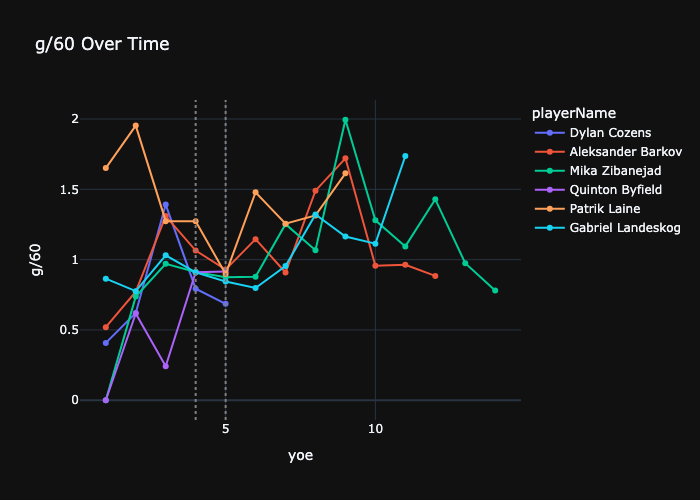

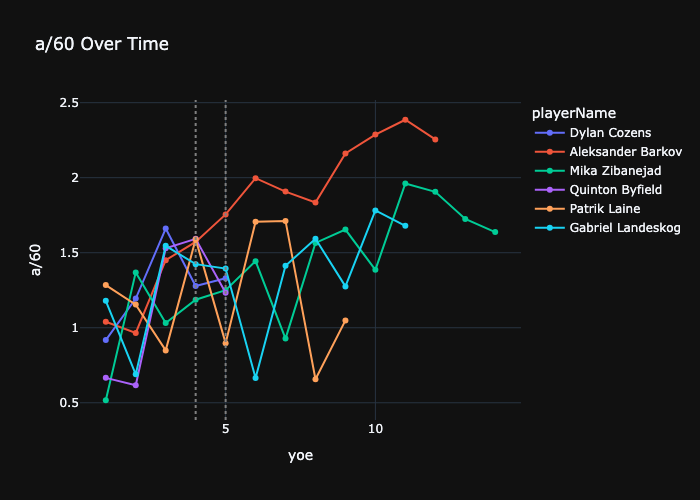

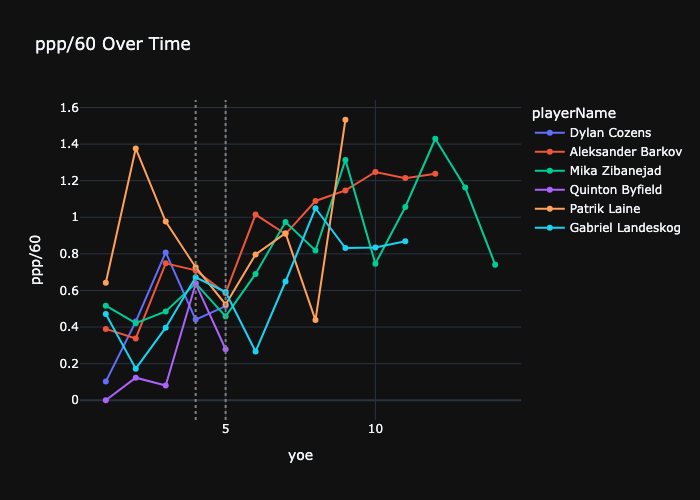

In [4]:
POSITION = "forwards" # {forwards, defensemen, goalies}
INPUT = "Cozens"
TIME_COL = "yoe"
LOOKBACK = 2
NUM_NEIGHBORS = 5

NBRS_DF, TIME_VALS = runner(POSITION, INPUT, TIME_COL, LOOKBACK, NUM_NEIGHBORS)
NBRS_DF = NBRS_DF.sort_values([TIME_COL])

def plot_stat(df, time_vals, stat):
    fig = px.line(
        data_frame=df,
        x=TIME_COL,
        y=stat,
        color="playerName",
        markers=True,
        labels={TIME_COL: TIME_COL, stat: stat},
        title=f"{stat} Over Time"
    )
    for s in time_vals:
        fig.add_vline(x=s, line_dash='dot', line_color='gray')


    fig.show()

plot_stat(NBRS_DF, TIME_VALS, "g/60")
plot_stat(NBRS_DF, TIME_VALS, "a/60")
plot_stat(NBRS_DF, TIME_VALS, "ppp/60")

In [6]:
BIO_STATS = load_bio_stats("forwards")
BIO_STATS = BIO_STATS.merge(NBRS_DF[["playerId", "playerName"]].drop_duplicates(), left_on="id", right_on="playerId", how="inner")
BIO_STATS

,id,positionCode,shootsCatches,heightInInches,weightInPounds,playerId,playerName
0,8476455,L,L,72.786131,215.251685,8476455,Gabriel Landeskog
1,8477493,C,L,75.485588,214.343641,8477493,Aleksander Barkov
2,8481528,C,R,75.280063,207.160904,8481528,Dylan Cozens
3,8482124,R,L,76.926472,225.205231,8482124,Quinton Byfield
4,8477946,C,L,72.991941,199.009732,8477946,Dylan Larkin
5,8476459,C,R,74.014042,203.013428,8476459,Mika Zibanejad


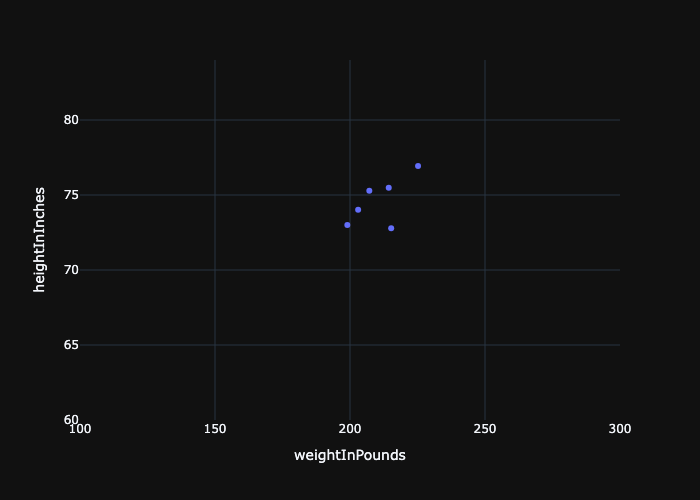

In [7]:
fig = px.scatter(
    BIO_STATS,
    x='weightInPounds',
    y='heightInInches',
    hover_name='playerName',
    range_x=(100, 300),
    range_y=(60, 84),
)
fig.show()